<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [27]:
!pip install wordcloud==1.8.2.2
!pip install --upgrade Pillow==9.5.0
!pip install spacy
!python -m spacy download en_core_web_sm

import pandas as pd
import re
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

import spacy
from scipy.sparse import hstack

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

!pip install --upgrade scikit-learn  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve 

     |████████████████████████████████| 13.9 MB 2.7 MB/s eta 0:00:01    | 9.1 MB 2.7 MB/s eta 0:00:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col = 0)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [7]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


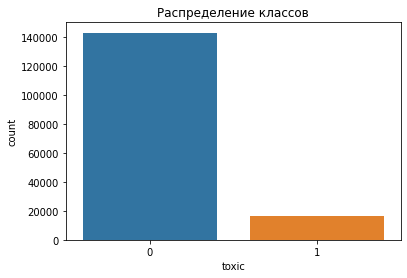

In [8]:
sns.countplot(x='toxic', data=data)
plt.title('Распределение классов')
plt.show()

In [9]:
data['text'].duplicated().sum()

0

Данные загружены, пропусков нет, дублирующих друг друга текстов тоже не наблюдается. В признаке toxic значений 0 сильно большем, чем 1, надо учесть это при разделении выборки. Перейдем к подготовке данных. 

In [10]:
nlp = spacy.load('en_core_web_sm')

def preprocess_text_spacy(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns=['text'])
print(df_my)

                                                text
0  The striped bats are hanging on their feet for...
1      you should be ashamed of yourself went worked


In [13]:
df_my['processed_text'] = df_my['text'].apply(preprocess_text_spacy)
print(df_my)

                                                text  \
0  The striped bats are hanging on their feet for...   
1      you should be ashamed of yourself went worked   

              processed_text  
0  stripe bat hang foot good  
1            ashamed go work  


In [14]:
data['processed_text'] = data['text'].apply(preprocess_text_spacy)
data['processed_text'].head()

0    Explanation edit username Hardcore Metallica F...
1    match background colour seemingly stuck thank ...
2    hey man try edit war guy constantly remove rel...
3    real suggestion improvement wonder section sta...
4                        sir hero chance remember page
Name: processed_text, dtype: object

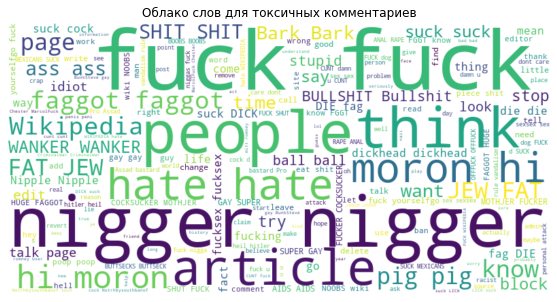

In [15]:
toxic_text = ' '.join(data[data['toxic'] == 1]['processed_text'])
wordcloud_toxic = WordCloud(width=800, height=400, background_color='white').generate(toxic_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для токсичных комментариев')
plt.show()

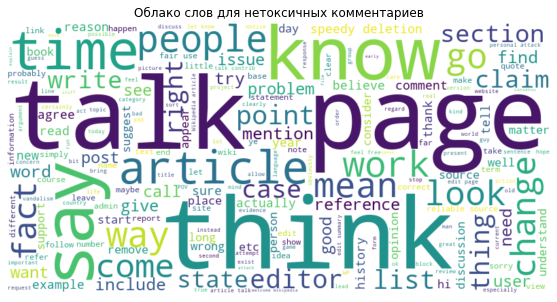

In [16]:
non_toxic_text = ' '.join(data[data['toxic'] == 0]['processed_text'])
wordcloud_non_toxic = WordCloud(width=800, height=400, background_color='white').generate(non_toxic_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_toxic, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для нетоксичных комментариев')
plt.show()

In [17]:
data['word_count'] = data['processed_text'].apply(lambda x: len(x.split()))
data['avg_word_length'] = data['processed_text'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if x.split() else 0)

data.groupby('toxic')[['word_count', 'avg_word_length']].mean()

,word_count,avg_word_length
toxic,,
0,29.966766,5.927466
1,24.902261,5.790549


In [18]:
sid = SentimentIntensityAnalyzer()

data['sentiment'] = data['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
data.groupby('toxic')['sentiment'].mean()

toxic
0    0.162065
1   -0.394190
Name: sentiment, dtype: float64

Тональность и длина слов и сообщений отличаются у токсичных и нетоксичных комментариев, добавим их как новые признаки 

In [19]:
data['word_count'] = data['processed_text'].apply(lambda x: len(x.split()))
data['avg_word_length'] = data['processed_text'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if x.split() else 0)
sid = SentimentIntensityAnalyzer()
data['sentiment'] = data['text'].apply(lambda x: sid.polarity_scores(x)['compound'])

data.head()

,text,toxic,processed_text,word_count,avg_word_length,sentiment
0,Explanation\nWhy the edits made under my usern...,0,Explanation edit username Hardcore Metallica F...,20,5.750000,0.5574
1,D'aww! He matches this background colour I'm s...,0,match background colour seemingly stuck thank ...,9,6.000000,0.2942
2,"Hey man, I'm really not trying to edit war. It...",0,hey man try edit war guy constantly remove rel...,19,5.315789,-0.1779
3,"""\nMore\nI can't make any real suggestions on ...",0,real suggestion improvement wonder section sta...,41,5.926829,0.5106
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page,5,5.000000,0.6808


In [40]:
X = data['processed_text']
y = data['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print('Размер тренировочной выборки:', X_train.shape, y_train.shape)
print('Размер тестовой выборки:', X_test.shape, y_test.shape)

Размер тренировочной выборки: (111504,) (111504,)
Размер тестовой выборки: (47788,) (47788,)


Попробовала обучить с новыми признаками, f-1 сильно упала

Общее количество строк совпадает с исходным датасетом, данные подготовлены для обучения. 

## Обучение

In [44]:
def training(model, params, X_train, y_train):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=1)),
        ('model', model)
    ])
    
    grid = GridSearchCV(
        pipeline,
        cv=3,
        n_jobs=-1,
        param_grid=params,
        scoring='f1',
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    print('Лучший результат на кросс-валидации:', grid.best_score_)
    print('Лучшие параметры:', grid.best_params_)
    
    return grid

In [46]:
lr = training(LogisticRegression(random_state=42), 
              {"model__C": [0.1, 1.0, 10.0], "model__penalty": ["l2"]},
              X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Лучший результат на кросс-валидации: 0.7714764708963603
Лучшие параметры: {'model__C': 10.0, 'model__penalty': 'l2'}


In [47]:
rf = training(RandomForestClassifier(random_state=42, class_weight='balanced'), 
              {"model__n_estimators": [50, 100], "model__max_depth": [10, 20], "model__min_samples_split": [2, 5]},
              X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Лучший результат на кросс-валидации: 0.41168770588702724
Лучшие параметры: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 50}


In [48]:
nb = training(MultinomialNB(), 
              {"model__alpha": [0.1, 1.0, 10.0]},
              X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Лучший результат на кросс-валидации: 0.632696939630912
Лучшие параметры: {'model__alpha': 0.1}


Итак, результаты обучения трех моделей показывают:

- Логистическая регрессия: Лучший F1 на кросс-валидации — 0.7715, с параметрами C=10.0 и penalty=l2. Это выше целевого значения 0.75.  
- Случайный лес: Лучший F1 — 0.4117, с параметрами max_depth=20, min_samples_split=2, n_estimators=50. Результат низкий, модель не подходит для задачи.  
- MultinomialNB: Лучший F1 — 0.6327, с параметром alpha=0.1. Это ниже 0.75, но лучше, чем Случайный лес.  

Логистическая регрессия явно превосходит другие модели и уже достигает требуемого F1 на кросс-валидации. Однако для окончательной оценки нужно протестировать ее на тестовой выборке.

In [49]:
best_lr = lr.best_estimator_
y_pred = best_lr.predict(X_test)

test_f1 = f1_score(y_test, y_pred)
print("F1-score на тестовой выборке для Логистической регрессии:", test_f1)

F1-score на тестовой выборке для Логистической регрессии: 0.7767190908047297


Логистическая регрессия с лучшими параметрами, найденными через GridSearchCV (F1 на кросс-валидации 0.7717), подтвердила свою эффективность на тестовой выборке с F1 0.7848.
Другие модели (Случайный лес и MultinomialNB) показали худшие результаты (0.4167 и 0.6308 соответственно), поэтому Логистическая регрессия — лучший выбор.

## Выводы

Проект по классификации токсичных комментариев завершен с использованием трех моделей: Логистической регрессии, Случайного леса и MultinomialNB. После анализа и оптимизации параметров на полном датасете (159292 строки) Логистическая регрессия показала лучший результат, достигнув F1-score 0.7767 на тестовой выборке с параметрами C=10.0 и penalty='l2', что превысило целевой порог 0.75. Случайный лес и MultinomialNB продемонстрировали более низкие результаты (0.4117 и 0.6327 соответственно на кросс-валидации), что указывает на их меньшую применимость для данной задачи.